# Traffic Violation RAG System
In this exam, you will implement a Retrieval-Augmented Generation (RAG) system that uses a language model and a vector database to answer questions about traffic violations. The goal is to generate answers with relevant data based on a dataset of traffic violations and fines.

Here are helpful resources:
* [LangChain](https://www.langchain.com/)
* [groq cloud documentation](https://console.groq.com/docs/models)
* [LangChain HuggingFace](https://python.langchain.com/docs/integrations/text_embedding/sentence_transformers/)
* [Chroma Vector Store](https://python.langchain.com/docs/integrations/vectorstores/chroma/)
* [Chroma Website](https://docs.trychroma.com/getting-started)
* [ChatGroq LangChain](https://python.langchain.com/docs/integrations/chat/groq/)
* [LLM Chain](https://api.python.langchain.com/en/latest/chains/langchain.chains.llm.LLMChain.html#langchain.chains.llm.LLMChain)

Dataset [source](https://www.moi.gov.sa/wps/portal/Home/sectors/publicsecurity/traffic/contents/!ut/p/z0/04_Sj9CPykssy0xPLMnMz0vMAfIjo8ziDTxNTDwMTYy83V0CTQ0cA71d_T1djI0MXA30gxOL9L30o_ArApqSmVVYGOWoH5Wcn1eSWlGiH1FSlJiWlpmsagBlKCQWqRrkJmbmqRqUZebngB2gUJAKdERJZmqxfkG2ezgAhzhSyw!!/)

Some installs if needed:
```python
!pip install langchain-huggingface langchain langchain-community langchain-chroma Chroma langchain-groq
```

In [1]:
!pip install PyArabic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 4.0 MB/s eta 0:00:00


In [2]:
!pip install langchain-huggingface langchain langchain-community langchain-chroma Chroma langchain-groq

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.2/599.2 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.1/405.1 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.0/290.0 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!kaggle datasets download -d khaledzsa/dataset
!unzip dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/dataset
License(s): unknown
  0% 0.00/3.73k [00:00<?, ?B/s]
100% 3.73k/3.73k [00:00<00:00, 9.55MB/s]
Archive:  dataset.zip
  inflating: Dataset.csv             


## Step 1: Install Required Libraries

To begin, install the necessary libraries for this project. The libraries include `LangChain` for building language model chains, and `Chroma` for managing a vector database.

In [4]:
# DA and helper libraries:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import re
# Import preprocessing tools (modules):
# Recursive text splitter to break down our data into chunks:
from langchain.text_splitter import RecursiveCharacterTextSplitter
# Save our embeddings into a vector db to load our query into it:
from langchain_community.vectorstores import Chroma
# Import the embeder:
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
# Models:
from langchain_groq import ChatGroq
from langchain.chains import LLMChain
from langchain_core.prompts import PromptTemplate

# Import Arabic lang preprocessing tools:
# Arabic lib:
import pyarabic.araby as araby
import pyarabic.number as number

# Import nltk for stopwords:
import nltk
from nltk.corpus import stopwords # Import stopwords so that we can take them out of our text later.
from nltk.stem.isri import ISRIStemmer # We'll use this module to return the arabic words to their base root form.
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in HuggingFaceInferenceAPIEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Step 2: Load the Traffic Violations Dataset

You are provided with a dataset of traffic violations. Load the CSV file into a pandas DataFrame and preview the first few rows of the dataset using `.head()`. You can also try and see the dataset's characteristics.

In [5]:
df = pd.read_csv('/content/Dataset.csv')

In [6]:
df.head()

,المخالفة,الغرامة
0,قيادة المركبة في الأسواق التي لا يسمح بالقيادة...,الغرامة المالية 100 - 150 ريال
1,ترك المركبة مفتوحة وفي وضع التشغيل بعد مغادرتها.,الغرامة المالية 100 - 150 ريال
2,عدم وجود تأمين ساري للمركبة.,الغرامة المالية 100 - 150 ريال
3,عبور المشاة للطرق من غير الأماكن المخصصة لهم.,الغرامة المالية 100 - 150 ريال
4,عدم تقيد المشاة بالإشارات الخاصة بهم.,الغرامة المالية 100 - 150 ريال


In [7]:
df.sample(5)

,المخالفة,الغرامة
27,عدم التقيد بتنظيمات السير عند تقاطعات الطرق.,الغرامة المالية 300 - 500 ريال
57,استعمال المركبة لغير الغرض الذي رخصت من أجله.,الغرامة المالية 500 - 900 ريال
0,قيادة المركبة في الأسواق التي لا يسمح بالقيادة...,الغرامة المالية 100 - 150 ريال
15,عدم ربط حزام الأمان.,الغرامة المالية 150 - 300 ريال
36,عدم الوقوف تماماً عند إشارة قف.,الغرامة المالية 500 - 900 ريال


In [8]:
df.tail()

,المخالفة,الغرامة
99,القيام بأعمال الطرق قبل التنسيق مع الإدارة الم...,الغرامة المالية 5000 - 10000 ريال
100,سماح أصحاب الحيوانات بعبور حيواناتهم من غير ال...,الغرامة المالية 5000 - 10000 ريال
101,استخدام لوحات غير عائدة للمركبة.,الغرامة المالية 5000 - 10000 ريال
102,طمس رقم هيكل المركبة أو محاولة طمسه.,الغرامة المالية 5000 - 10000 ريال
103,المجازفة بعبور الأودية والشعاب أثناء جريانها.,الغرامة المالية 5000 - 10000 ريال


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   المخالفة  104 non-null    object
 1   الغرامة   104 non-null    object
dtypes: object(2)
memory usage: 1.8+ KB


# EDA

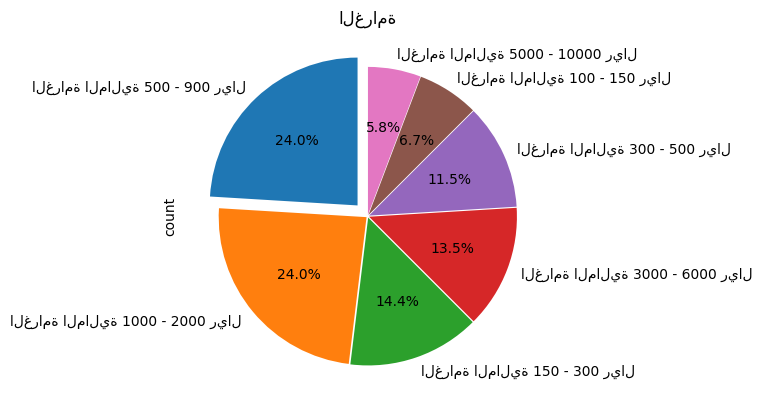

In [10]:
df['الغرامة'].value_counts().plot(kind='pie',autopct='%1.1f%%',startangle=90, explode=(0.1, 0.01, 0.01, 0.01, 0.01,0.01,0.01))
plt.title('الغرامة')
plt.show()

In [11]:
# Get the maximum number of rows per each vio to help us with chunking our data.
max_len_vio = 0
for row in df['المخالفة']:
  text_length = len(row)
  if text_length > max_len_vio:
    max_len_vio = text_length

# Min len:
min_len_vio = max_len_vio
for row in df['المخالفة']:
  text_length = len(row)
  if text_length < min_len_vio:
    min_len_vio = text_length

print(f'The maximum length of a violation in the df: {max_len_vio}')
print(f'The minimum length of a violation in the df: {min_len_vio}')

The maximum length of a violation in the df: 141
The minimum length of a violation in the df: 18


In [12]:
st = ISRIStemmer() # Initialize instance of our arabic stemmer.
def clean_text(text):
  # The following will clean our text from urls and english letters:
  #              re.sub(          pattern         ,replace, string)
  cleaned_text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
  # remove english letters:
  cleaned_text = re.sub(r'@[A-Za-z0-9_]+', '', cleaned_text)

  # remove special characters:
  cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)

  # remove harakat:
  cleaned_text = araby.strip_tashkeel(cleaned_text)
  # remove tashkeel:
  cleaned_text = araby.strip_tatweel(cleaned_text)
  # remove lastharaka:
  cleaned_text = araby.strip_lastharaka(cleaned_text)

  # Tokenize the words using araby.tokenize:
  words = araby.tokenize(cleaned_text) # This will split our text into tokens (words).

  # After tokenizing let's remove the stop words:
  # Make a set of stop words, then by looping through the whole tokenized text check if the word is a stop word by checking whether if it's in the stop words set.
  arb_stopwords = set(stopwords.words("arabic")) # This will create a set of all arabic stop words.
  filtered_words = [] # This is where we'll save our tokens without the stop words
  for word in words:
    if word not in arb_stopwords:
      filtered_words.append(word)

  # Return our text to it's stem:
  word_stem = []
  for word in filtered_words:  # Apply stemming only to filtered words
      word_stem.append(st.stem(word))

  stemmed_sentence = ' '.join(word_stem)


  # Normalize hamza:
  filtered_text = araby.normalize_hamza(stemmed_sentence)

  return filtered_text

In [13]:
df['مخالفة_نظيف'] = df['المخالفة'].apply(clean_text)
df['الغرامة_نظيف'] = df['الغرامة'].apply(clean_text)

## Step 3: Create Markdown Content from the Dataset

For each traffic violation in the dataset, you will generate markdown text that describes the violation and the associated fine. Create a loop to iterate through the dataset and store the generated markdown in a list. Each fine should look like this:

**المخالفة** - الغرامة

In [92]:
directory = 'Mardowns/markdown_files'
os.makedirs(directory, exist_ok = True)

In [93]:
# Let's create a function that creates a markedown file per each row as each row has 'Violation' and 'Fine'
markdown_texts = []
for i in range(0,104):
  # Get each title and content per row:
  Violation = df['مخالفة_نظيف'].iloc[i]
  Fine = df['الغرامة_نظيف'].iloc[i]
  # Set up the markdown content:
  markdown_content = f'**{Violation}** {Fine}'
  markdown_texts.append(markdown_content)
  # Create a markdown file per each index with the required text:
  with open(f'{directory}/{i}.md', 'w', encoding = 'utf-8') as file:
      file.write(markdown_content)

In [94]:
for markdown in markdown_texts:
  print(markdown)
  print('*'*100)

**قيد ركب سوق سمح قيد** غرم الة 100 150
****************************************************************************************************
**ركب فتح وفي وضع شغل غدر** غرم الة 100 150
****************************************************************************************************
**عدم وجد تءم سري ركب** غرم الة 100 150
****************************************************************************************************
**عبر شاة طرق اما خصص** غرم الة 100 150
****************************************************************************************************
**عدم تقد شاة اشر خصة** غرم الة 100 150
****************************************************************************************************
**وقف ركب اما خصص وقف** غرم الة 100 150
****************************************************************************************************
**عدم عطء فضل رور شاة ثنء عبر سار خصص** غرم الة 100 150
**********************************************************************************************

## Step 4: Chunk the Markdown Data

Using LangChain's `RecursiveCharacterTextSplitter`, split the markdown texts into smaller chunks that will be stored in the vector database.

In [95]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=35)
documents = text_splitter.create_documents(markdown_texts)

## Step 5: Generate Embeddings for the Documents

Generate embeddings for the chunks of text using HuggingFace's pre-trained Arabic language model. These embeddings will be stored in a `Chroma` vector store.

In [96]:
embedding_function = SentenceTransformerEmbeddings(model_name="Omartificial-Intelligence-Space/GATE-AraBert-v0")
db = Chroma.from_documents(documents, embedding_function, persist_directory="./chroma_db")

## Step 6: Define the RAG Prompt Template

Define a custom prompt template in Arabic to retrieve traffic violation-related answers based on the context. Ensure the template greets the user first, states that the information provided could be incorrect, and advises the user to visit the traffic initiative website to verify. Additionally, provide the user with advice in Arabic, ensuring it stays within the given context.

In [97]:
prompt_temp = """
اولا القي التحية على المستخدم
--------
سلم ايضا
--------
ثانيا اخبر المستخدم ان المعلومات من الممكن ان تكون خطا والافضل ان يزور موقع المرور
--------
السوال: {question}
--------
السياق: {fine}
--------
اعطي نصيحة عن الموضوع{question} مثال: اذا سال عن مخالفة سرعة اخبره الاجابة {fine} بعدها اخبره ان الافضل ان لا يسرع وهذا امن اكثر
--------
رشح اسئلة اخرى للمستخدم
--------
ودع المستخدم بلطف وذكره بقيمة الغرامة
"""
prompt = PromptTemplate(
    input_variables=["question", "fine"],
    template= prompt_temp,
)

## Step 7: Initialize the Language Model

Initialize the language model using the Groq API. Set up the model with a specific configuration, including the API key, temperature setting, and model name.

In [98]:
groq_api_key = "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"
llm = ChatGroq(temperature=0, groq_api_key=groq_api_key, model_name="llama-3.1-70b-versatile")

## Step 8: Create the LLM Chain

Now, you will create an LLM Chain that combines the language model and the prompt template you defined. This chain will be used to generate responses based on the retrieved context.

In [99]:
llm_chain = LLMChain(
    llm = llm,
    prompt = prompt,
    verbose = True
)

## Step 9: Implement the Query Function

Create a function `query_rag` that will take a user query as input, retrieve relevant context from the vector store, and use the language model to generate a response based on that context.

In [100]:
def query_rag(query: str):
  results = db.similarity_search_with_relevance_scores(query, k=4)
  context = ""

  for result in results:
    # if result[1] >= 0.7:
    context = result[0].page_content
    print(context)
    response = llm_chain.invoke({"fine": context, "question": query})

  return response

## Step 10: Inference - Running Queries in the RAG System

In this final step, you will implement an inference pipeline to handle real-time queries. You will allow the system to retrieve the most relevant violations and fines based on a user's input and generate a response.

1. Inference Workflow:

  * The user inputs a query (e.g., "ماهي عقوبة عدم الوقوف وقوفاً تاماً عند إشارة؟").
  * The system searches for the most relevant context from the traffic violation vector store.
  * It generates an answer and advice based on the context.

2. Goal:
  * Run the inference to answer questions based on the traffic violation dataset.

In [101]:
infrence = query_rag("ماهي عقوبة عدم الوقوف وقوفاً تاماً عند إشارة؟")
infrence['text']

<ipython-input-100-c9ba12982f78>:2: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={}, page_content='**عدم الوقوف تماماً عند إشارة قف.** الغرامة المالية 500 - 900 ريال'), -221.67148164556872), (Document(metadata={}, page_content='**عدم الوقوف وقوفاً تاماً عند إشارة (أمامك أفضلية) في حالة مرور مركبات على الطريق المعطاة له الأفضلية.** الغرامة المالية 500 - 900 ريال'), -228.57364916518728), (Document(metadata={}, page_content='**عدم الوقوف عند مراكز الضبط الأمني أو نقاط التفتيش أو عدم الوقوف للدورية الأمنية عند وجود توجيه أو علامة توجب الوقوف.** الغرامة المالية 3000 - 6000 ريال'), -241.62243214968547), (Document(metadata={}, page_content='**عدم التقيد بإشارات رجل الأمن اليدوية عند تنظيمه للحركة وعدم إعطاء إشارته الأولوية على الإشارات الضوئية.** الغرامة المالية 500 - 900 ريال'), -242.4542666284812)]
  results = db.similarity_search_with_relevance_scores(query, k=4)


**عدم الوقوف تماماً عند إشارة قف.** الغرامة المالية 500 - 900 ريال
Prompt after formatting:

اولا القي التحية على المستخدم
--------
سلم ايضا
--------
ثانيا اخبر المستخدم ان المعلومات من الممكن ان تكون خطا والافضل ان يزور موقع المرور
--------
السوال: ماهي عقوبة عدم الوقوف وقوفاً تاماً عند إشارة؟
--------
السياق: **عدم الوقوف تماماً عند إشارة قف.** الغرامة المالية 500 - 900 ريال
--------
اعطي نصيحة عن الموضوعماهي عقوبة عدم الوقوف وقوفاً تاماً عند إشارة؟ مثال: اذا سال عن مخالفة سرعة اخبره الاجابة **عدم الوقوف تماماً عند إشارة قف.** الغرامة المالية 500 - 900 ريال بعدها اخبره ان الافضل ان لا يسرع وهذا امن اكثر
--------
رشح اسئلة اخرى للمستخدم
--------
ودع المستخدم بلطف وذكره بقيمة الغرامة




> Finished chain.
**عدم الوقوف وقوفاً تاماً عند إشارة (أمامك أفضلية) في حالة مرور مركبات على الطريق المعطاة له الأفضلية.** الغرامة المالية 500 - 900 ريال
Prompt after formatting:

اولا القي التحية على المستخدم
--------
سلم ايضا
--------
ثانيا اخبر المستخدم ان المعلومات من الممكن ان تكون خطا والافضل ان يزور موقع المرور
--------
السوال: ماهي عقوبة عدم الوقوف وقوفاً تاماً عند إشارة؟
--------
السياق: **عدم الوقوف وقوفاً تاماً عند إشارة (أمامك أفضلية) في حالة مرور مركبات على الطريق المعطاة له الأفضلية.** الغرامة المالية 500 - 900 ريال
--------
اعطي نصيحة عن الموضوعماهي عقوبة عدم الوقوف وقوفاً تاماً عند إشارة؟ مثال: اذا سال عن مخالفة سرعة اخبره الاجابة **عدم الوقوف وقوفاً تاماً عند إشارة (أمامك أفضلية) في حالة مرور مركبات على الطريق المعطاة له الأفضلية.** الغرامة المالية 500 - 900 ريال بعدها اخبره ان الافضل ان لا يسرع وهذا امن اكثر
--------
رشح اسئلة اخرى للمستخدم
--------
ودع المستخدم بلطف وذكره بقيمة الغرامة




> Finished chain.
**عدم الوقوف عند مراكز الضبط الأمني أو نقاط التفتيش أو عدم الوقوف للدورية الأمنية عند وجود توجيه أو علامة توجب الوقوف.** الغرامة المالية 3000 - 6000 ريال
Prompt after formatting:

اولا القي التحية على المستخدم
--------
سلم ايضا
--------
ثانيا اخبر المستخدم ان المعلومات من الممكن ان تكون خطا والافضل ان يزور موقع المرور
--------
السوال: ماهي عقوبة عدم الوقوف وقوفاً تاماً عند إشارة؟
--------
السياق: **عدم الوقوف عند مراكز الضبط الأمني أو نقاط التفتيش أو عدم الوقوف للدورية الأمنية عند وجود توجيه أو علامة توجب الوقوف.** الغرامة المالية 3000 - 6000 ريال
--------
اعطي نصيحة عن الموضوعماهي عقوبة عدم الوقوف وقوفاً تاماً عند إشارة؟ مثال: اذا سال عن مخالفة سرعة اخبره الاجابة **عدم الوقوف عند مراكز الضبط الأمني أو نقاط التفتيش أو عدم الوقوف للدورية الأمنية عند وجود توجيه أو علامة توجب الوقوف.** الغرامة المالية 3000 - 6000 ريال بعدها اخبره ان الافضل ان لا يسرع وهذا امن اكثر
--------
رشح اسئلة اخرى للمستخدم
--------
ودع المستخدم بلطف وذكره بقيمة الغرامة




> Finished chain.
**عدم التقيد بإشارات رجل الأمن اليدوية عند تنظيمه للحركة وعدم إعطاء إشارته الأولوية على الإشارات الضوئية.** الغرامة المالية 500 - 900 ريال
Prompt after formatting:

اولا القي التحية على المستخدم
--------
سلم ايضا
--------
ثانيا اخبر المستخدم ان المعلومات من الممكن ان تكون خطا والافضل ان يزور موقع المرور
--------
السوال: ماهي عقوبة عدم الوقوف وقوفاً تاماً عند إشارة؟
--------
السياق: **عدم التقيد بإشارات رجل الأمن اليدوية عند تنظيمه للحركة وعدم إعطاء إشارته الأولوية على الإشارات الضوئية.** الغرامة المالية 500 - 900 ريال
--------
اعطي نصيحة عن الموضوعماهي عقوبة عدم الوقوف وقوفاً تاماً عند إشارة؟ مثال: اذا سال عن مخالفة سرعة اخبره الاجابة **عدم التقيد بإشارات رجل الأمن اليدوية عند تنظيمه للحركة وعدم إعطاء إشارته الأولوية على الإشارات الضوئية.** الغرامة المالية 500 - 900 ريال بعدها اخبره ان الافضل ان لا يسرع وهذا امن اكثر
--------
رشح اسئلة اخرى للمستخدم
--------
ودع المستخدم بلطف وذكره بقيمة الغرامة


> Finished chain.


'تحية طيبة للمستخدم الكريم.\n\nسلمت يداك على هذا السؤال المهم.\n\nيجب أن نلاحظ أن المعلومات قد تكون غير دقيقة أو قد تتغير، لذلك يفضل دائمًا زيارة موقع المرور الرسمي للحصول على المعلومات الأكثر دقة.\n\nالآن، للإجابة على سؤالك: عقوبة عدم الوقوف وقوفًا تامًا عند إشارة هي الغرامة المالية 500 - 900 ريال.\n\nنصيحتي لك: من الأفضل دائمًا أن تتبع إشارات المرور وتقيد بها، حيث أن ذلك يضمن سلامتك وسلامة الآخرين على الطريق. إذا لم تقف وقوفًا تامًا عند إشارة، قد تتعرض لغرامة مالية، ولكن أكثر من ذلك، قد تتعرض لخطر الحوادث.\n\nإذا كنت تريد معرفة المزيد عن مخالفات المرور، يمكنني أن أرشح لك بعض الأسئلة الأخرى:\n\n* ما هي عقوبة عدم إعطاء الأولوية للسيارات القادمة من اليمين؟\n* ما هي عقوبة عدم استخدام حزام الأمان؟\n* ما هي عقوبة تجاوز السرعة المسموحة على الطريق السريع؟\n\nوداعًا لك، ولا تنسى أن الغرامة المالية لعدم الوقوف وقوفًا تامًا عند إشارة هي 500 - 900 ريال.'

In [102]:
infrence['text']

'تحية طيبة للمستخدم الكريم.\n\nسلمت يداك على هذا السؤال المهم.\n\nيجب أن نلاحظ أن المعلومات قد تكون غير دقيقة أو قد تتغير، لذلك يفضل دائمًا زيارة موقع المرور الرسمي للحصول على المعلومات الأكثر دقة.\n\nالآن، للإجابة على سؤالك: عقوبة عدم الوقوف وقوفًا تامًا عند إشارة هي الغرامة المالية 500 - 900 ريال.\n\nنصيحتي لك: من الأفضل دائمًا أن تتبع إشارات المرور وتقيد بها، حيث أن ذلك يضمن سلامتك وسلامة الآخرين على الطريق. إذا لم تقف وقوفًا تامًا عند إشارة، قد تتعرض لغرامة مالية، ولكن أكثر من ذلك، قد تتعرض لخطر الحوادث.\n\nإذا كنت تريد معرفة المزيد عن مخالفات المرور، يمكنني أن أرشح لك بعض الأسئلة الأخرى:\n\n* ما هي عقوبة عدم إعطاء الأولوية للسيارات القادمة من اليمين؟\n* ما هي عقوبة عدم استخدام حزام الأمان؟\n* ما هي عقوبة تجاوز السرعة المسموحة على الطريق السريع؟\n\nوداعًا لك، ولا تنسى أن الغرامة المالية لعدم الوقوف وقوفًا تامًا عند إشارة هي 500 - 900 ريال.'